## Homework Natural Language Processing

In deze notebook ga je een **sentiment analyse** doen op de reviews die bezoekers op Trip Advisor achterlieten na het bezoeken van 1 van de pretparken van Disney. Ga experimenteel na hoe je een goed voorspellend model kan bouwen om het sentiment van een review te voorspellen, puur aan de hand van de woorden (features) in de review. 

Je bouwt deze notebook __stap per stap op__. Voorzie volgende onderdelen in je notebook :

- Stap 1 : data inlezen en voorbereiden
- Stap 2 : NLP pipeline *(zie ook theorie)*
- Stap 3 : Model opstellen: Experimenteer met volgende 3 methodes
    * Gebruik de NLTK library & Vader 
    * Gebruik een Bag-of-Words approach in combinatie met een klassiek ML algoritme
    * Gebruik een RNN model
- Stap 4 : Conclusie

Voorzie tevens in elke stap een __woordje uitleg over de keuzes__ die je maakt en de __resultaten__ die je hiermee bekomt. 
</br>Geef ook een vergelijking tussen de 3 methodes.

<img src="img/disneyland.jpeg" alt="Disneyland"
	title="Disneyland" width="800" height="400" />

De **verbetersleutel** ziet er als volgt uit:


|  Stap    | #punten | 
|-----------|:--------:|
|  Stap 1: |     /1   |  
|  Stap 2: |     /4   |  
|  Stap 3: |        |  
|  ---> 3.1 |     /2    |  
|  ---> 3.2 |      /4| 
|  ---> 3.3 |      /4   |  
| Stap 4:|     /2    |
| Rapportering :|     /3   |  
|      Totaal: |     /20    | 


### Praktische afspraken:
Dit project wordt ingediend door deze notebook verder thuis af te werken en te uploaden op Toledo voor de start van je labo in **de week van maandag 10 januari 2022**

#### Alvast veel succes!

### Stap 1 : data inladen

De data bestaat uit een .csv file die rechtstreeks ingeladen kan worden. De belangrijkste kolommen zijn uiteraard de _Review_text_ en de _Rating_ kolom. De ratings gaan van een waarde 1 tot 5, waarbij 5 uitstekend is (heel positieve review) en 1 een slechte review. </br>Modeleer hieruit een classificatieprobleem (je hoeft zeker geen 5 klassen te behouden, herwerk bvb naar een binaire classificatie of eventueel naar een probleem met 3 klassen (positief neutraal, negatief).

Ga na of er waarden ontbreken, zo ja verwijder deze data.
Ga na hoeveel data je per categorie hebt. 

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator    

nltk.download(['stopwords', 'vader_lexicon', 'punkt'])

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/louisdhont/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv("../data/DisneylandReviews.csv",encoding='latin-1')
original_df = df
df.sample(5)

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
5127,329197035,5,2014-12,India,one can opt for day visit here or stay at the ...,Disneyland_HongKong
41173,131333892,3,2012-6,United Kingdom,I recently went to both parks with my all adul...,Disneyland_Paris
19168,274297420,5,2014-11,Canada,Just a great time for all but make sure you ha...,Disneyland_California
16969,328430700,4,2015-11,United States,"Still an amazing place to be, but sooooooooo b...",Disneyland_California
8268,152572238,3,2012-6,Australia,"With all the hype that surrounds Disney, I exp...",Disneyland_HongKong


In [4]:
## to remove the duplicates data
df.drop_duplicates(subset='Review_ID', inplace=True, keep='first')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42636 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42636 non-null  int64 
 1   Rating             42636 non-null  int64 
 2   Year_Month         42636 non-null  object
 3   Reviewer_Location  42636 non-null  object
 4   Review_Text        42636 non-null  object
 5   Branch             42636 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.3+ MB


In [6]:
df=df.dropna().reset_index()
print ("Missing values: ", df.isnull().sum().values.sum())
df.head()

Missing values:  0


,index,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [7]:
df.drop(columns=['index', 'Review_ID', 'Year_Month', 'Reviewer_Location'], inplace=True)

In [8]:
#df.isnull().sum()/len(df)

print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values: ", df.isnull().sum().values.sum())
print ("Unique values:\n",df.nunique())

Rows     :  42636
Columns  :  3

Features : 
 ['Rating', 'Review_Text', 'Branch']

Missing values:  0
Unique values:
 Rating             5
Review_Text    42624
Branch             3
dtype: int64


In [9]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42636 entries, 0 to 42635
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Rating       42636 non-null  int64 
 1   Review_Text  42636 non-null  object
 2   Branch       42636 non-null  object
dtypes: int64(1), object(2)
memory usage: 999.4+ KB


In [10]:
#df['Review_Text'].values[2:3]

In [11]:
df.head()

,Rating,Review_Text,Branch
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong


In [12]:
rating_count = df.Rating.value_counts()
rating_count

5    23137
4    10768
3     5105
2     2127
1     1499
Name: Rating, dtype: int64

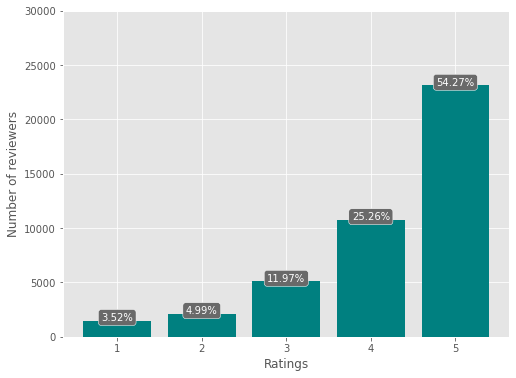

In [13]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(rating_count.index, rating_count.values, color='teal')
    for r, val in zip(rating_count.index, rating_count.values):
        plt.text(r, val, 
                 str(round(val/sum(rating_count.values)*100, 2))+'%', 
                 ha='center', color='white', 
                 bbox=dict(facecolor='dimgrey', edgecolor='white', boxstyle="round"))
    plt.xlabel('Ratings')
    plt.ylabel('Number of reviewers')
    plt.yticks(np.arange(0, 30001, 5000))

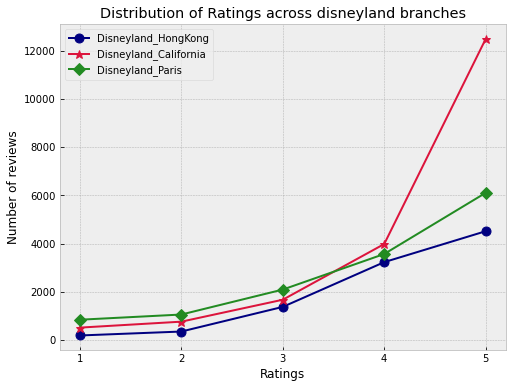

In [14]:
markers = ['o', '*', 'D']
branch_col = ['navy', 'crimson', 'forestgreen']
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 6))
    for branch, m, col in zip(df.Branch.unique(), markers, branch_col):
        counts = df[df.Branch == branch]['Rating'].value_counts()
        x = counts.index
        y = counts.values
        plt.plot(x, y, marker=m, markersize=9, color=col, label=branch)
        plt.xticks(np.arange(1, 6))
        plt.xlabel('Ratings')
        plt.ylabel('Number of reviews')
    plt.title('Distribution of Ratings across disneyland branches')
    plt.legend()
    plt.show()

In [15]:
df.head()

,Rating,Review_Text,Branch
0,4,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,4,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,4,"the location is not in the city, took around 1...",Disneyland_HongKong


In [16]:
### Generate word clouds
stopwords = set(STOPWORDS)
stopwords.update(["park", "parks", "ride", "rides", "Disney", "Disneyland"])

(-0.5, 1599.5, 799.5, -0.5)

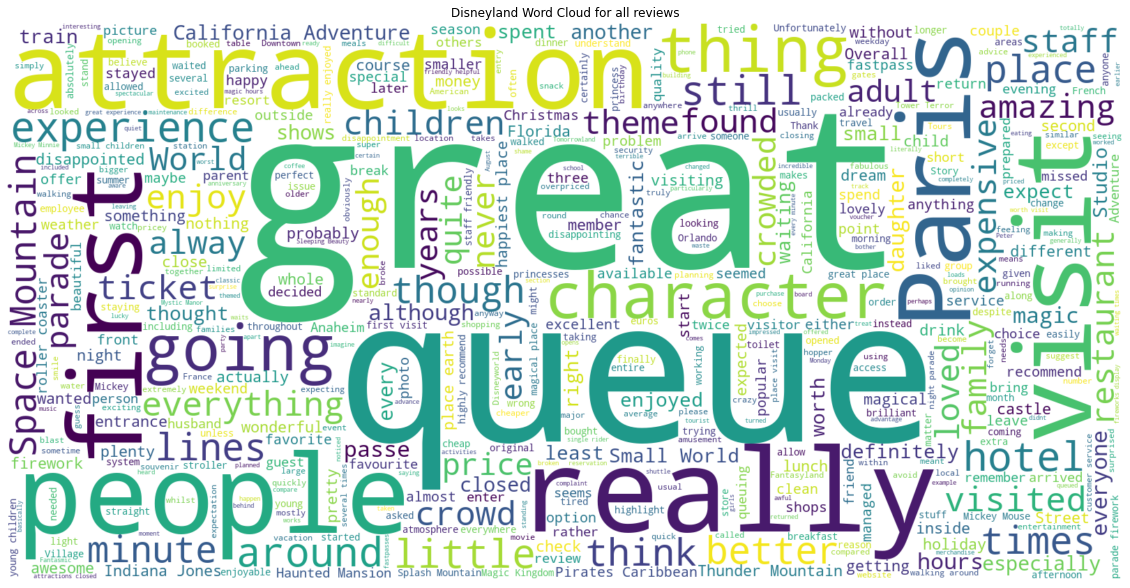

In [17]:
### Disneyland Parks overall word cloud

text = " ".join(review for review in df.Review_Text)

plt.figure(figsize=(20, 20))
wc = WordCloud(stopwords=stopwords, max_words=500, width=1600, height=800, min_word_length=5, background_color='white').generate(text)
plt.title("Disneyland Word Cloud for all reviews")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

In [18]:
### Separate Disneyland dataframes into there scores
score_1 = df.loc[df['Rating'] == 1]
score_2 = df.loc[df['Rating'] == 2]
score_3 = df.loc[df['Rating'] == 3]
score_4 = df.loc[df['Rating'] == 4]
score_5 = df.loc[df['Rating'] == 5]

(-0.5, 399.5, 199.5, -0.5)

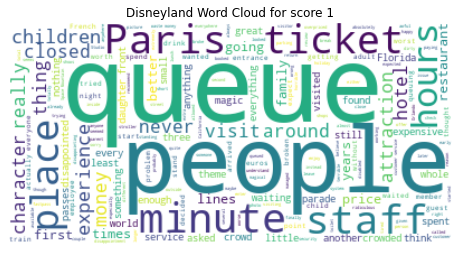

In [19]:
text1 = " ".join(review for review in score_1.Review_Text)

plt.figure(figsize=(8, 10))
wc = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text1)
plt.title("Disneyland Word Cloud for score 1")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

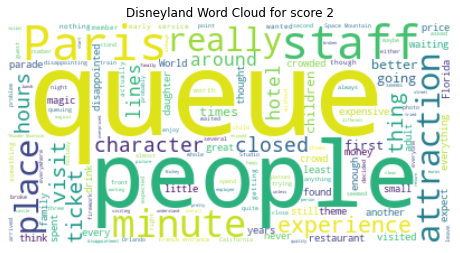

In [20]:
text2 = " ".join(review for review in score_2.Review_Text)

plt.figure(figsize=(8, 10))
wc2 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text2)
plt.title("Disneyland Word Cloud for score 2")
plt.imshow(wc2, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

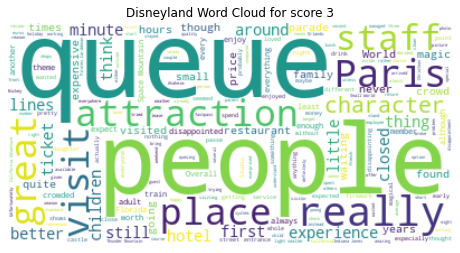

In [21]:
text3 = " ".join(review for review in score_3.Review_Text)

plt.figure(figsize=(8, 10))
wc3 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text3)
plt.title("Disneyland Word Cloud for score 3")
plt.imshow(wc3, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

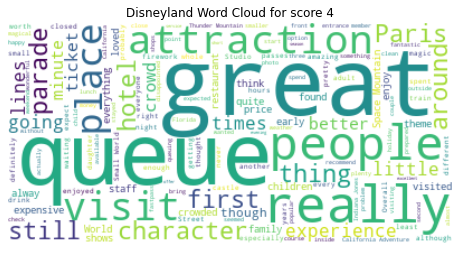

In [22]:
text4 = " ".join(review for review in score_4.Review_Text)

plt.figure(figsize=(8, 10))
wc4 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text4)
plt.title("Disneyland Word Cloud for score 4")
plt.imshow(wc4, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

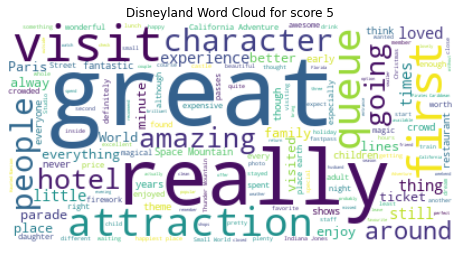

In [23]:
text5 = " ".join(review for review in score_5.Review_Text)

plt.figure(figsize=(8, 10))
wc5 = WordCloud(stopwords=stopwords, max_words=500, min_word_length=5, background_color='white').generate(text5)
plt.title("Disneyland Word Cloud for score 5")
plt.imshow(wc5, interpolation='bilinear')
plt.axis('off')

### Stap 2 : Text Processing Pipeline

Voorzie volgende stappen. Je kan hiervoor gebruik maken van de __NLTK library in Python__ (zie bv. https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk).

De keuze voor vectorizatie kies je in de volgende stap, die keuze is immers afhankelijk van hoe je de uitwerking gaat doen).
Uiteindelijk moet elke review vertaald worden naar een zin waarin volgende aanpassingen gebeuren :

1. **Tokenization**: split elke review in woorden, zodat je er de volgende stappen kan op loslaten

2. **Punctuation removal** : 
      je kan volgende punctuations verwijderen uit de review : "!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
      
3. **Stopword Removal**: 
    de nltk.corpus module voorziet een lijst van stopwoorden die je kan gebruiken om te verwijderen uit de reviews:
          
        import nltk
        from nltk.corpus import stopwords
        
    Deze moet je vooraf wel downloaden bvb via cmd line : _python -m nltk.downloader stopwords_
        
4. **Lower casing / negation handling**

5. **Lemmatizing / Stemming** : Kies in deze stap voor Lemmatizing of Stemming. Voer beiden eens uit, kijk naar de verschillen en maak een keuze.
    Zowel Lemmatizing als Stemming kan je via de NLTK library uitvoeren. zie bvb. https://www.geeksforgeeks.org/python-lemmatization-with-nltk/ en https://www.geeksforgeeks.org/python-stemming-words-with-nltk/.
    Als je wordnet wil gebruiken zal je deze ook eerst moeten downloaden: 
   
    python -m nltk downloader wordnet



In [24]:
df['Original_Text'] = df['Review_Text']

### Tokenizen, Lower casing & Punctuation removal

In [25]:
def tokenize(column):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(column)
    return [w.lower() for w in tokens if w.isalpha()]

df['tokenized'] = df.apply(lambda row: tokenize(row['Review_Text']), axis=1)

### Stopwords removal

In [26]:
def remove_stopwords(tokenized_column):
    return [word for word in tokenized_column if not word in stopwords]

df['stopwords_removed'] = df.apply(lambda x: remove_stopwords(x['tokenized']), axis=1)

In [27]:
print("Tokenized text: ", df['tokenized'][19])
print()
print("With stopwords removed: ", df['stopwords_removed'][19])

Tokenized text:  ['there', 'is', 'nothing', 'more', 'to', 'say', 'except', 'that', 'you', 'become', 'a', 'child', 'once', 'again', 'as', 'you', 'step', 'inside', 'disneyland', 'in', 'hk', 'easy', 'to', 'go', 'and', 'come', 'out', 'with', 'dedicated', 'trams', 'and', 'subway', 'stations', 'wait', 'for', 'the', 'parade', 'at', 'sunset', 'it', 'is', 'definitely', 'worth', 'waiting']

With stopwords removed:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicated', 'trams', 'subway', 'stations', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'waiting']


### Lemmatizing / Stemming

In [28]:
def apply_porterstemmer(tokenized_column):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokenized_column]

def apply_wordnetlemmatizer(tokenized_column):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word, "v") for word in tokenized_column]

#df['porter_stemmed'] = df.apply(lambda x: apply_porterstemmer(x['stopwords_removed']), axis=1)
df['word_lemmatized'] = df.apply(lambda x: apply_wordnetlemmatizer(x['stopwords_removed']), axis=1) #porter_stemmed

lem = WordNetLemmatizer()
stem = PorterStemmer()
word = "nothing"
print("Diffrence between Lemmatizing and Stemming for the word:", word)
print("Lemmatized Word:",lem.lemmatize(word, "v"))
print("Stemmed Word:",stem.stem(word))

Diffrence between Lemmatizing and Stemming for the word: nothing
Lemmatized Word: nothing
Stemmed Word: noth


In [29]:
print("Lemmatized text: ", df['word_lemmatized'][19])

Lemmatized text:  ['nothing', 'say', 'except', 'become', 'child', 'step', 'inside', 'disneyland', 'hk', 'easy', 'go', 'come', 'dedicate', 'tram', 'subway', 'station', 'wait', 'parade', 'sunset', 'definitely', 'worth', 'wait']


In [30]:
### Drop useless columns and rename columns
df.drop(columns=['stopwords_removed', 'Branch', 'tokenized', 'Review_Text'], inplace=True) #'porter_stemmed'
df.rename(columns={'word_lemmatized': 'Review_Text', 'Rating': 'Sentiment'}, inplace=True)
df.head()

,Sentiment,Original_Text,Review_Text
0,4,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately..."
4,4,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k..."


In [31]:
#Voorbeeld tonen van tokenized woorden voor een willekeur

tokenized_words = df['Review_Text'][283]
print(tokenized_words)

['people', 'themepark', 'one', 'small', 'much', 'attractions', 'name', 'people', 'flock', 'place', 'countries', 'good', 'disney', 'one']


### Stap 3 : Sentiment analysis 

Ga na wat de kwaliteit is van Sentiment analyse op de reviews via volgende 3 technieken :

1. Gebruik de ingebouwde sentiment analyzer VADER (Valence Aware Dictionary end sEntiment Reasoner) van de NLTL library (Zie ook: https://realpython.com/python-nltk-sentiment-analysis).

2. Gebruik een Bag-of-Words techniek via CountVectorizer en TFIDFVectorizer. Gebruik na deze vectorizatie een klassiek classificatie-algoritme om je data te trainen en testen (Zie ook: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/ of https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/).

3. Gebruik een deep learning RNN en TensorFlow/Keras om je sentiment voorspeller te bouwen. Hieronder vind je enkele voorbeelden waaruit je inspiratie kan opdoen.

### Inspiratie files


- Text classification with RNN : https://www.tensorflow.org/text/tutorials/text_classification_rnn
- RNN with Keras (https://www.tensorflow.org/text/tutorials/text_classification_rnn)
- https://www.kaggle.com/abhimanyu314/tripadvisor-rnn
- https://www.kaggle.com/deepakvedantam/imdb-review-sentimental-analysis-with-keras
- https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

# VADER analyser

In [32]:
# build train and test datasets
#from sklearn.model_selection import train_test_split

#reviews_data = df['Review_Text'].values.tolist()
#y_sentiment = df['Rating'].values.tolist()

#train_reviews, test_reviews, train_sentiments, test_sentiments =\
#    train_test_split(reviews_data,y_sentiment, test_size=0.20,  random_state=101)

In [33]:
vaderdf = df.copy()
vaderdf

,Sentiment,Original_Text,Review_Text
0,4,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately..."
4,4,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k..."
...,...,...,...
42631,5,i went to disneyland paris in july 03 and thou...,"[go, disneyland, paris, july, think, brilliant..."
42632,5,2 adults and 1 child of 11 visited Disneyland ...,"[adults, child, visit, disneyland, paris, begi..."
42633,5,My eleven year old daughter and myself went to...,"[eleven, year, old, daughter, go, visit, son, ..."
42634,4,"This hotel, part of the Disneyland Paris compl...","[hotel, part, disneyland, paris, complex, wond..."


In [34]:
sid = SentimentIntensityAnalyzer()

vaderdf['score'] = vaderdf['Original_Text'].apply(lambda review: sid.polarity_scores(review))
vaderdf['score']

0        {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...
1        {'neg': 0.04, 'neu': 0.73, 'pos': 0.231, 'comp...
2        {'neg': 0.024, 'neu': 0.742, 'pos': 0.235, 'co...
3        {'neg': 0.08, 'neu': 0.76, 'pos': 0.16, 'compo...
4        {'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...
                               ...                        
42631    {'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...
42632    {'neg': 0.02, 'neu': 0.776, 'pos': 0.204, 'com...
42633    {'neg': 0.021, 'neu': 0.881, 'pos': 0.098, 'co...
42634    {'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp...
42635    {'neg': 0.026, 'neu': 0.806, 'pos': 0.168, 'co...
Name: score, Length: 42636, dtype: object

In [35]:
vaderdf['comp_score'] = vaderdf['score'].apply(lambda d:d['compound'])

In [36]:
vaderdf['comp_score']

0        0.7069
1        0.9901
2        0.9920
3        0.8489
4        0.2846
          ...  
42631    0.9860
42632    0.9909
42633    0.8402
42634    0.9538
42635    0.9782
Name: comp_score, Length: 42636, dtype: float64

In [37]:
vaderdf

,Sentiment,Original_Text,Review_Text,score,comp_score
0,4,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan...","{'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'comp...",0.7069
1,4,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti...","{'neg': 0.04, 'neu': 0.73, 'pos': 0.231, 'comp...",0.9901
2,4,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ...","{'neg': 0.024, 'neu': 0.742, 'pos': 0.235, 'co...",0.9920
3,4,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately...","{'neg': 0.08, 'neu': 0.76, 'pos': 0.16, 'compo...",0.8489
4,4,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k...","{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'comp...",0.2846
...,...,...,...,...,...
42631,5,i went to disneyland paris in july 03 and thou...,"[go, disneyland, paris, july, think, brilliant...","{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...",0.9860
42632,5,2 adults and 1 child of 11 visited Disneyland ...,"[adults, child, visit, disneyland, paris, begi...","{'neg': 0.02, 'neu': 0.776, 'pos': 0.204, 'com...",0.9909
42633,5,My eleven year old daughter and myself went to...,"[eleven, year, old, daughter, go, visit, son, ...","{'neg': 0.021, 'neu': 0.881, 'pos': 0.098, 'co...",0.8402
42634,4,"This hotel, part of the Disneyland Paris compl...","[hotel, part, disneyland, paris, complex, wond...","{'neg': 0.0, 'neu': 0.847, 'pos': 0.153, 'comp...",0.9538


In [38]:
vaderdf.groupby('Sentiment')['comp_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Sentiment,,,,,,,,
1,1499.0,-0.073156,0.734202,-0.9977,-0.8121,-0.2230,0.7128,0.9985
2,2127.0,0.167029,0.712625,-0.9974,-0.5731,0.3819,0.8720,0.9987
3,5105.0,0.436347,0.622431,-0.9910,0.0000,0.7469,0.9341,0.9994
4,10768.0,0.730292,0.407319,-0.9911,0.7003,0.9025,0.9674,0.9999
5,23137.0,0.812239,0.295473,-0.9701,0.7986,0.9235,0.9715,0.9999


# Bag-of-Words techniek with CountVectorizer & TFIDFVectorizer

In [105]:
bowdf = df.copy()
bowdf

,Sentiment,Original_Text,Review_Text
0,4,If you've ever been to Disneyland anywhere you...,"[ve, disneyland, anywhere, ll, find, disneylan..."
1,4,Its been a while since d last time we visit HK...,"[d, last, time, visit, hk, disneyland, yet, ti..."
2,4,Thanks God it wasn t too hot or too humid wh...,"[thank, god, wasn, t, hot, humid, visit, big, ..."
3,4,HK Disneyland is a great compact park. Unfortu...,"[hk, disneyland, great, compact, unfortunately..."
4,4,"the location is not in the city, took around 1...","[location, city, take, around, hour, kowlon, k..."
...,...,...,...
42631,5,i went to disneyland paris in july 03 and thou...,"[go, disneyland, paris, july, think, brilliant..."
42632,5,2 adults and 1 child of 11 visited Disneyland ...,"[adults, child, visit, disneyland, paris, begi..."
42633,5,My eleven year old daughter and myself went to...,"[eleven, year, old, daughter, go, visit, son, ..."
42634,4,"This hotel, part of the Disneyland Paris compl...","[hotel, part, disneyland, paris, complex, wond..."


In [106]:
#token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize)

#bowdf['text_cv'] = bowdf['Review_Text'].apply(lambda review: cv.fit_transform(review))
#bowdf['text_cv'] = bowdf['text_cv'].apply(lambda x: x.toarray())
#bowdf['text_cv']

## CountVectorizer

### LogisticRegression with the Count Vectorizer data

In [107]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(bowdf.Original_Text, bowdf.Sentiment, test_size=0.2, random_state=1)

X_test_cv, X_val_cv, y_test_cv, y_val_cv = train_test_split(X_test_cv, y_test_cv, test_size=0.5, random_state=1)

In [108]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_cv = count_vectorizer.fit_transform(X_train_cv)
X_val_cv = count_vectorizer.transform(X_val_cv)
X_test_cv = count_vectorizer.transform(X_test_cv)

In [109]:
count_vectorizer.get_feature_names()[300:320]

['all it',
 'all loved',
 'all my',
 'all of',
 'all other',
 'all our',
 'all over',
 'all rides',
 'all so',
 'all staff',
 'all that',
 'all the',
 'all there',
 'all these',
 'all they',
 'all things',
 'all this',
 'all those',
 'all to',
 'all very']

In [110]:
count_vectorizer.vocabulary_['like']

4611

In [101]:
logreg = LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=5).fit(X_train_cv, y_train_cv)
select_features = SelectFromModel(logreg, prefit=True)

X_train_sel_cv = select_features.transform(X_train_cv)
X_test_sel_cv = select_features.transform(X_test_cv)
X_val_sel_cv = select_features.transform(X_val_cv)

model_cv = LogisticRegression(solver='saga', max_iter=5).fit(X_train_sel_cv, y_train_cv)
model_cv_score = model_cv.score(X_val_sel_cv, y_val_cv)

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [102]:
print('Accuracy trained model:', model_cv_score)

Accuracy trained model: 0.5727016885553471


In [120]:
print("Test Base Accuracy: %2.2f \n" % (model_cv.score(X_test_sel_cv, y_test_cv)* 100))

y_pred_cv = model_cv.predict(X_test_sel_cv)
print('Confusion matrix')
print(confusion_matrix(y_pred_cv, y_test_cv))
print()
print(classification_report(y_test_cv, y_pred_cv))

Test Base Accuracy: 57.15 

Confusion matrix
[[   3    0    0    1    5]
 [   3    3    1    1    2]
 [  56   59   77   41   33]
 [  34   69  191  193  118]
 [  67   98  233  815 2161]]

              precision    recall  f1-score   support

           1       0.33      0.02      0.03       163
           2       0.30      0.01      0.03       229
           3       0.29      0.15      0.20       502
           4       0.32      0.18      0.23      1051
           5       0.64      0.93      0.76      2319

    accuracy                           0.57      4264
   macro avg       0.38      0.26      0.25      4264
weighted avg       0.49      0.57      0.50      4264



### LogisticRegression with the TFIDF Vectorizer data

In [111]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(bowdf.Original_Text, bowdf.Sentiment, test_size=0.2, random_state=1)

X_test_tf, X_val_tf, y_test_tf, y_val_tf = train_test_split(X_test_tf, y_test_tf, test_size=0.5, random_state=1)

In [112]:
tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_tf = tf_vectorizer.fit_transform(X_train_tf)
X_val_tf = tf_vectorizer.transform(X_val_tf)
X_test_tf = tf_vectorizer.transform(X_test_tf)

In [98]:
logreg = LogisticRegression(solver='saga', penalty='l1', C=10, max_iter=10).fit(X_train_tf, y_train_tf)
select_features = SelectFromModel(logreg, prefit=True)
    
X_train_sel_tf = select_features.transform(X_train_tf)
X_test_sel_tf = select_features.transform(X_test_tf)
X_val_sel_tf = select_features.transform(X_val_tf)

model_tf = LogisticRegression(solver='saga', max_iter=10).fit(X_train_sel_tf, y_train_tf)
model_tf_score = model_tf.score(X_val_sel_tf, y_val_tf)

/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [99]:
print('Accuracy trained model:', model_tf_score)

Accuracy trained model: 0.6360225140712945


In [119]:
print("Test Base Accuracy: %2.2f \n" % (model_tf.score(X_test_sel_tf, y_test_tf)* 100))

y_pred_tf = model_tf.predict(X_test_sel_tf)
print('Confusion matrix')
print(confusion_matrix(y_pred_tf, y_test_tf))
print()
print(classification_report(y_test_tf, y_pred_tf))

Test Base Accuracy: 62.38 

Confusion matrix
[[  47   27   11    2    2]
 [  33   26   16    4    0]
 [  57  101  190   75   20]
 [   8   43  157  357  257]
 [  18   32  128  613 2040]]

              precision    recall  f1-score   support

           1       0.53      0.29      0.37       163
           2       0.33      0.11      0.17       229
           3       0.43      0.38      0.40       502
           4       0.43      0.34      0.38      1051
           5       0.72      0.88      0.79      2319

    accuracy                           0.62      4264
   macro avg       0.49      0.40      0.42      4264
weighted avg       0.59      0.62      0.60      4264



The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier. The core principle is to convert text documents into numeric vectors. The dimension or size of each vector is N where N indicates all possible distinct words across the corpus of documents. Each document once transformed is a numeric vector of size N where the values or weights in the vector indicate the frequency of each word in that specific document. Hence the name bag of words because this model represents unstructured text into a bag of words without taking into account word positions, syntax, or semantics.

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these will tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency, which uses a combination of two metrics in its computation, namely: term frequency (tf) and inverse document frequency (idf). This technique was developed for ranking results for queries in search engines and now it is an indispensable model in the world of information retrieval and text analytics.

In [615]:
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        

def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, target_names):
    total_classes = len(target_names)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Sentiment:'], target_names], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], target_names], labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, target_names):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)

In [616]:
reviews_data = df['Original_Text'].values.tolist()
y_sentiment = df['Sentiment'].values.tolist()

train_reviews, test_reviews, train_sentiments, test_sentiments =\
    train_test_split(reviews_data, y_sentiment, test_size=0.20,  random_state=101)

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)

# transform test reviews into features
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)

print('BOW model: Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model: Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model: Train features shape: (34108, 700662)  Test features shape: (8528, 700662)
TFIDF model: Train features shape: (34108, 700662)  Test features shape: (8528, 700662)


In [617]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm = SGDClassifier(loss='hinge', l1_ratio=0.15, max_iter=300, n_jobs=4, random_state=101)

In [618]:
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, train_features=cv_train_features, train_labels=train_sentiments,
                                         test_features=cv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                  target_names=['1', '2', '3', '4', '5'])

Model Performance metrics:
------------------------------
Accuracy:  61.67% 
Precision: 59.82% 
Recall:    61.67% 
F1 Score:  60.54% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.48      0.40      0.44       316
           2       0.26      0.24      0.25       396
           3       0.44      0.39      0.41      1071
           4       0.44      0.38      0.40      2182
           5       0.75      0.83      0.79      4563

    accuracy                           0.62      8528
   macro avg       0.47      0.45      0.46      8528
weighted avg       0.60      0.62      0.61      8528



/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [558]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = train_predict_model(classifier=lr, train_features=tv_train_features, train_labels=train_sentiments,
                                           test_features=tv_test_features, test_labels=test_sentiments)
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                  target_names=['1', '2', '3', '4', '5'])

Model Performance metrics:
------------------------------
Accuracy:  62.78% 
Precision: 59.01% 
Recall:    62.78% 
F1 Score:  59.24% 

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.66      0.17      0.27       316
           2       0.28      0.09      0.13       396
           3       0.44      0.34      0.38      1071
           4       0.45      0.35      0.40      2182
           5       0.71      0.91      0.80      4563

    accuracy                           0.63      8528
   macro avg       0.51      0.37      0.40      8528
weighted avg       0.59      0.63      0.59      8528



/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# RNN model

In [ ]:
### Drop Rating column
df.drop(columns=['Rating'], inplace=True)

In [ ]:
reviews_data = df['Review_Text'].values.tolist()
y_sentiment = df['Sentiment'].values.tolist()

In [ ]:
df.Sentiment.value_counts()

In [ ]:
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews_data, y_sentiment, test_size=0.5, random_state=42)

In [ ]:
#rnn_reviews_train, rnn_reviews_test, rnn_y_train, rnn_y_test = train_test_split(reviews_data, y_sentiment, test_size = 0.5, random_state = 42)


In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(oov_token=True)
tokenizer.fit_on_texts(reviews_train)

In [ ]:
#tokenizer.word_index

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

reviews_train_tk = tokenizer.texts_to_sequences(reviews_train)
reviews_test_tk = tokenizer.texts_to_sequences(reviews_test)

In [ ]:
#reviews_train_tk

In [ ]:
#from sklearn.metrics import plot_confusion_matrix

#plot_confusion_matrix(logreg, reviews_test_tk, rnn_y_test)  
#plt.show()

In [104]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

reviews = df['Review_Text'].values.tolist()
y = df['Sentiment'].values.tolist()

reviews_train, reviews_test, y_train, y_test = train_test_split(
    reviews, y, test_size=0.5, random_state=42)

tokenizer = keras.preprocessing.text.Tokenizer(oov_token = True)
tokenizer.fit_on_texts(reviews_train)

In [105]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

reviews_train_tk = tokenizer.texts_to_sequences(reviews_train)
reviews_test_tk = tokenizer.texts_to_sequences(reviews_test)

max_length = 300

padded_reviews = pad_sequences(reviews_train_tk, maxlen=max_length, padding='post')

x_train, x_valid, y_train, y_valid = train_test_split(padded_reviews, y_train, test_size=0.20, shuffle= True)

y_train = np.array(y_train)
y_valid = np.array(y_valid)

x_train = np.array([np.array(xi) for xi in x_train])
x_valid = np.array([np.array(xi) for xi in x_valid])

In [110]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(
    input_dim = len(tokenizer.word_index) +1, 
    output_dim= 128,
    input_shape=[None],
    mask_zero=True))
model.add(keras.layers.Bidirectional(keras.layers.GRU(
    units = 64, dropout=0.4, recurrent_dropout=0.4)))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
    metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train, epochs = 1, validation_data=(x_valid, y_valid),
                    callbacks=[es], batch_size = 100)

KeyboardInterrupt: 

### Bag of Words model

In [329]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(text_counts, df['Sentiment'], test_size=0.3, random_state=1)

In [112]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation

from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print("MultinomialNB Accuracy:", metrics.accuracy_score(y_test, predicted))

train_score_ = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print('Train Accuracy:', train_score)
print('Test Accuracy:', test_score)

NameError: name 'X_train' is not defined

### Stap 4 : Conclusie

Becommentarieer je 3 gebruikte methodes en motiveer de keuzes die je gemaakt hebt. Maak een vergelijking tussen de methodes en geef aan waarom een methode volgens jou minder / beter presteert.